In [1]:
import numpy as np
import math
from scipy import signal
from matplotlib import pyplot as plt

In [2]:
def plot_signal(title, x_label, y_label, x, y):
    plt.title(title)
    plt.plot(x, y)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid()
    fig = plt.gcf()
    fig.set_size_inches(14, 8)
    plt.show()

def Q(a):
    return 0.5 * math.erfc(a / np.sqrt(2))

In [3]:
μ = 0
E = 1
bit_count = 10000
fs = 250
samples_count = 10

# Requirement 3

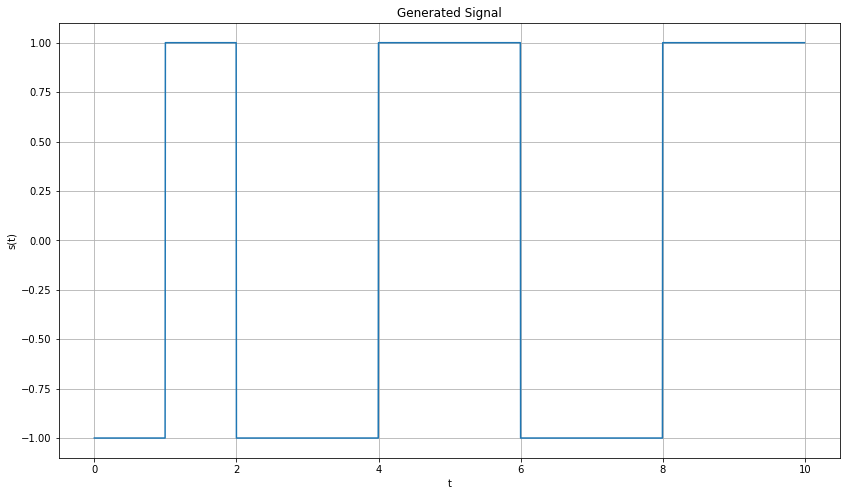

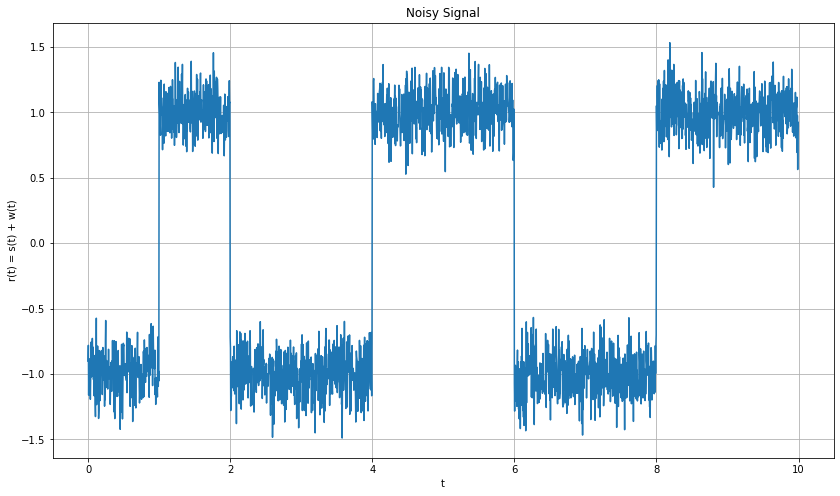

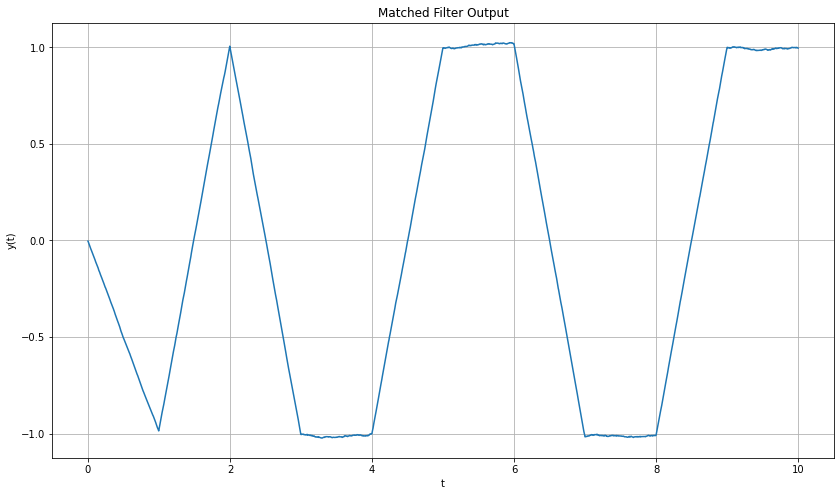

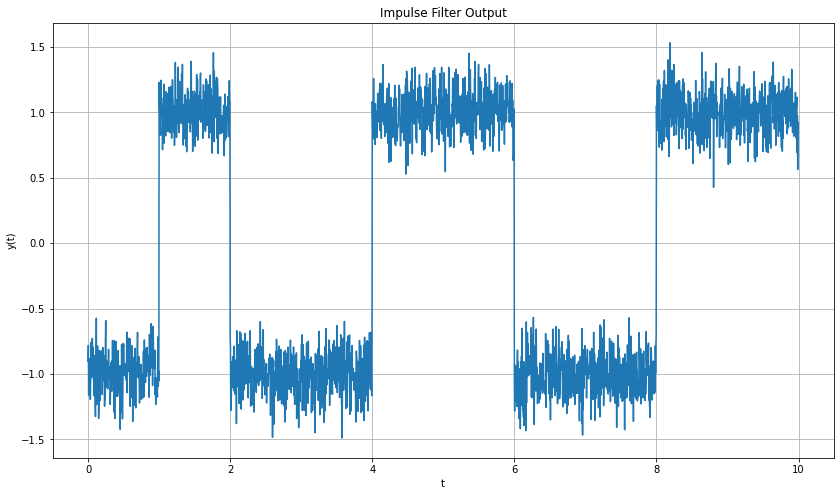

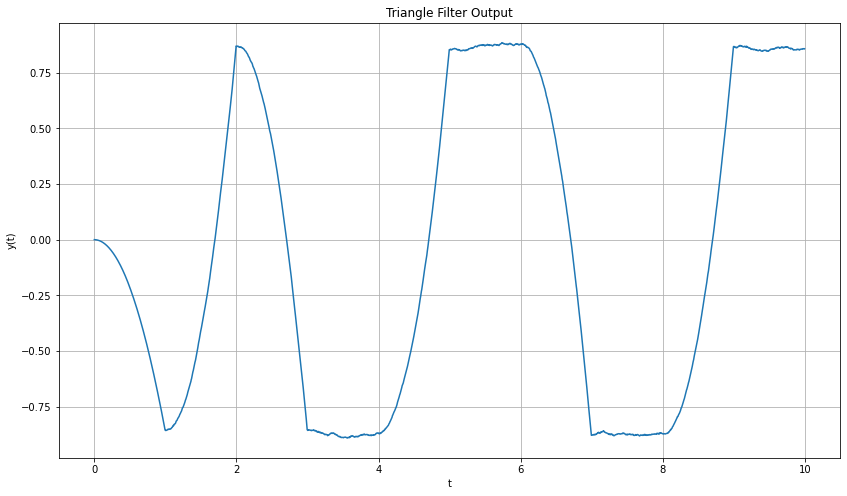

In [4]:
time = np.arange(0, bit_count, 1 / fs)
bit_size = int(np.round(len(time) / bit_count))

matched_filter = np.ones(bit_size)
impulse_filter = np.zeros(bit_size)
impulse_filter[0] = 1
triangle_filter = np.sqrt(3) * time[0: bit_size]


bit_stream = np.random.choice([0, 1], size=bit_count, p=[0.5, 0.5])

s = np.ones(len(time))
for k in range(0, bit_count):
    if(bit_stream[k] == 0):
        s[k * bit_size : (k + 1) * bit_size] = -1


N0 = E / (10 ** (5 / 10))

σ = N0 / 2

w = np.random.normal(loc=μ, scale=σ, size=len(s))
r = s + w

matched_filter_output = np.convolve(r, matched_filter, mode='full') / fs
impulse_filter_output = np.convolve(r, impulse_filter, mode='full')
triangle_filter_output = np.convolve(r, triangle_filter, mode='full') / fs


plot_signal('Generated Signal', 't', 's(t)', time[0: 10 * bit_size], s[0: 10 * bit_size])
plot_signal('Noisy Signal', 't', 'r(t) = s(t) + w(t)', time[0: 10 * bit_size], r[0: 10 * bit_size])
plot_signal('Matched Filter Output', 't', 'y(t)', time[0: 10 * bit_size], matched_filter_output[0: 10 * bit_size])
plot_signal('Impulse Filter Output', 't', 'y(t)', time[0: 10 * bit_size], impulse_filter_output[0: 10 * bit_size])
plot_signal('Triangle Filter Output', 't', 'y(t)', time[0: 10 * bit_size], triangle_filter_output[0: 10 * bit_size])

# Requirement 4

In [5]:
# constants
NUM_BITS = 100000
NUM_SAMPLES_PER_BIT = 20
OPTIMUM_λ = 0

In [6]:
def scaleSignal(signal):
    '''
    Converts the signal to a train of pulses
    '''
    return np.ones((signal.shape[0], NUM_SAMPLES_PER_BIT)) # scale the signal to a train of pulses
def quantizeSignal(originalSignal, modifiedSignal):
    '''
    Make the signal to be quantized(discrete) 
    '''
    for i in range(originalSignal.shape[0]):
        modifiedSignal[i, :] *= originalSignal[i]
    return modifiedSignal # the signal is now quantized
def noiseSignal(originalSignal, modifiedSignal, noise):
    '''
    Add the passed noise to the original signal
    '''
    for i in range(originalSignal.shape[0]):
        modifiedSignal[i, :] += noise[i*NUM_SAMPLES_PER_BIT:(i+1)*NUM_SAMPLES_PER_BIT]
    return modifiedSignal # the noise is now added to the signal

def addWhiteGaussianNoiseToSignal(signal, standardDeviation):
    '''
    Add WGN to the signal
    '''
    noise = np.random.normal(loc=0, scale=standardDeviation, size=NUM_SAMPLES_PER_BIT*NUM_BITS) # generate the noise

    received_samples = scaleSignal(signal) # scale the signal to a train of pulses
    received_samples = quantizeSignal(signal, received_samples) # quantize the signal
    received_samples = noiseSignal(signal, received_samples, noise) # add noise to the signal

    return received_samples


In [7]:
def applyFilter(signal, appliedFilter):
    '''
    Apply the filter to the signal by using convolution 
    '''
    def sampleSignal(signal):
        sampledSignal =  np.zeros(NUM_BITS)
        for i in range(NUM_BITS):
            sampledSignal[i] = signal[(NUM_SAMPLES_PER_BIT - 1) + NUM_SAMPLES_PER_BIT * i]
        return sampledSignal # the signal is now sampled

    if (appliedFilter is not None):
        filteredSignal = np.convolve(signal.flatten(), appliedFilter)
    else: # in case no filter was passed, just return the signal flattened (no filtering)
        filteredSignal = signal.flatten()

    return sampleSignal(filteredSignal) # return the sampled version of the filtered signal

In [8]:
def calcPracticalBitErrorRate(transmittedSignal, receivedSignal):
    '''
    Calculate the practical(actual) bit error rate
    '''
    actualSignal = np.ones(transmittedSignal.shape[0]) # scale the signal to a train of pulses
    actualSignal += (-2 * (receivedSignal < OPTIMUM_λ)) # lambda optimum = 0
    return np.sum(actualSignal != transmittedSignal) /transmittedSignal.shape[0] # return the error bit rate

def calcTheoreticalBitErrorRate(hyperparameterERFC):
    '''
    Calculate the Theoretical bit error rate
    '''
    return math.erfc(hyperparameterERFC) # use ERFC to calculate the theoretical bit error rate


In [9]:
# Generate the transimitted signal
transmitted_signal = np.random.choice([-1, 1], size=(NUM_BITS), p=[1./2, 1./2])


# Here, we apply 4 types of filters to the transmitted signal and compare their effect on the bit error rate
# Matched filter
matchedFilter = np.ones(NUM_SAMPLES_PER_BIT)
matchedFilterPracticalBitRateError = []
matchedFilterTheoreticalBitRateError = []

# No filter
noFilter = None
noFilterPracticalBitRateError  = []
noFilterTheoreticalBitRateError = []

# Impulse filter
impulseFilter = signal.unit_impulse(NUM_SAMPLES_PER_BIT, 'mid')
impulseFilterPracticalBitRateError  = []
impulseFilterTheoreticalBitRateError = []

# Ramp filter
rampFilter = np.random.uniform(low=0, high=5**0.5, size=NUM_SAMPLES_PER_BIT)
rampFilterPracticalBitRateError = []
rampFilterTheoreticalBitRateError = []

E = 1
MIN_NOISE_VALUE = -10
MAX_NOISE_VALUE = 21
NOISE_RANGE = range(MIN_NOISE_VALUE, MAX_NOISE_VALUE)
for divE_No_db in NOISE_RANGE:
    divE_No = 10 ** (divE_No_db/10)
    rootDivE_No = divE_No ** 0.5
    received_samples = addWhiteGaussianNoiseToSignal(transmitted_signal, E/(2*divE_No))

    matchedFilterPracticalBitRateError.append(calcPracticalBitErrorRate(transmitted_signal, applyFilter(received_samples, matchedFilter)))
    matchedFilterTheoreticalBitRateError.append(calcTheoreticalBitErrorRate(rootDivE_No))

    impulseFilterPracticalBitRateError.append(calcPracticalBitErrorRate(transmitted_signal, applyFilter(received_samples, impulseFilter)))
    impulseFilterTheoreticalBitRateError.append(calcTheoreticalBitErrorRate(rootDivE_No))

    noFilterPracticalBitRateError.append(calcPracticalBitErrorRate(transmitted_signal, applyFilter(received_samples, noFilter)))
    noFilterTheoreticalBitRateError.append(calcTheoreticalBitErrorRate(rootDivE_No))

    rampFilterPracticalBitRateError.append(calcPracticalBitErrorRate(transmitted_signal, applyFilter(received_samples, rampFilter)))
    rampFilterTheoreticalBitRateError.append(calcTheoreticalBitErrorRate((5**0.5)*0.5 * rootDivE_No))


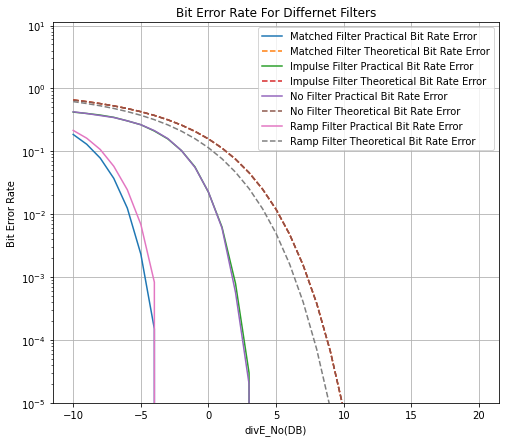

In [10]:
#ploting
plt.figure(figsize=(8,7))
plt.xlabel('divE_No(DB)')
plt.ylabel('Bit Error Rate')
plt.yscale('log')
plt.ylim(10**(-5))
plt.title('Bit Error Rate For Differnet Filters')


plt.plot(NOISE_RANGE, matchedFilterPracticalBitRateError, label = "Matched Filter Practical Bit Rate Error")
plt.plot(NOISE_RANGE, matchedFilterTheoreticalBitRateError, "--", label = "Matched Filter Theoretical Bit Rate Error")

plt.plot(NOISE_RANGE, impulseFilterPracticalBitRateError, label = "Impulse Filter Practical Bit Rate Error")
plt.plot(NOISE_RANGE, impulseFilterTheoreticalBitRateError, "--", label = "Impulse Filter Theoretical Bit Rate Error")

plt.plot(NOISE_RANGE, noFilterPracticalBitRateError, label = "No Filter Practical Bit Rate Error")
plt.plot(NOISE_RANGE, noFilterTheoreticalBitRateError, "--", label = "No Filter Theoretical Bit Rate Error")

plt.plot(NOISE_RANGE, rampFilterPracticalBitRateError, label = "Ramp Filter Practical Bit Rate Error")
plt.plot(NOISE_RANGE, rampFilterTheoreticalBitRateError, "--", label = "Ramp Filter Theoretical Bit Rate Error")


plt.legend()
plt.grid()
plt.show()